In [1]:
import os.path

import nibabel as nib
import numpy as np
import pandas as pd

global fig
%matplotlib widget
%matplotlib inline

from skopt.utils import use_named_args, cook_initial_point_generator
from skopt.space import Integer
from skopt import gp_minimize

########################
### Custom functions ###
########################
from src.loss_func import DC, get_yield, hellinger_distance
from src.phos_elect import create_grid, implant_grid, get_phosphenes
### needed for matrix rotation/translation ect
from src.ninimplant import get_xyz
import src.utils as utils
import src.visualizations as visualizations

import src.generate_visual_sectors as gvs

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# added because: "invalid value encountered in True-divide"
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [2]:
# determine range of parameters
DIM1 = Integer(name='alpha', low=-90, high=90)  # visual degrees
DIM2 = Integer(name='beta', low=-15, high=110)  # visual degrees - -15 is probably lowest possible angle, otherwise other hem is in the way if hem = RH -> low = -110, high = 15
DIM3 = Integer(name='offset_from_base', low=0, high=40)     # in mm
DIM4 = Integer(name='shank_length', low=10, high=20)    # in mm
DIMENSIONS = [DIM1, DIM2, DIM3, DIM4]
CONFIG = utils.read_config("config.json")
X0 = (CONFIG["INIT_ALPHA"], CONFIG["INIT_BETA"], CONFIG["INIT_OFFSET_FROM_BASE"], CONFIG["INIT_SHANK_LENGTH"])

In [3]:
@use_named_args(dimensions=DIMENSIONS)
def f(alpha, beta, offset_from_base, shank_length):
    """This function encapsulates the electrode placement procedure and returns the cost value by
    comparing the resulting phosphene map with the target map. Be the design of skopt, it can
    only take the objective function's parameters as arguments, so other variables used within
    the function should be defined as global.

    * First it creates a grid based on the four parameters.
    * Phosphenes are generated based on the grid's contact points,
      and their sizes are determined using cortical magnification and spread values.
    * These phosphenes are converted into a 2D image representation.
      The function then computes the dice coefficient and yield, and calculates
      the Hellinger distance between the generated image and a target density.
    * The resulting cost is a combination of these factors,
      with penalties applied if the grid is invalid.
    * The function also handles cases of invalid values and prints diagnostic information.

    Parameters
    ----------
    The decorators @use_named_args allows to call the function without
    specifying the parameters, since dimensions is a list with the parameters.

    Returns
    -------
    int or float
        The calculated cost used by the bayesopt algorithm
    """
    global CONFIG
    # global variables defined in main
    global start_location, gm_mask, target_density, bin_thresh
    # global coordinates and maps from the mri scans defined in main
    global good_coords, good_coords_V1, polar_map, ecc_map, sigma_map
    # global variables related to the previous array
    global iter_count, total_contacts_xyz_moved, valid_grids, overlap_valid_grids
    global arr_current, optimized_arrays_from_f_manual
    # cost functions
    global arr_dices, total_dices, arr_yields, total_yields, arr_HDs, total_HDs, arr_costs, total_costs

    grid_valid_overlap = True
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)

    # create grid
    orig_grid = create_grid(start_location, shank_length, CONFIG["N_CONTACTPOINTS_SHANK"], CONFIG["N_COMBS"],
                            CONFIG["N_SHANKS_PER_COMB"], CONFIG["SPACING_ALONG_XY"], offset_from_origin=0)

    # implanting grid
    all_output = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)
    cur_contacts_xyz_moved, grid_valid_convex_hull = all_output[1], all_output[-1]

    if arr_current <= 1:
        new_contacts_xyz_moved = cur_contacts_xyz_moved
        grid_valid = grid_valid_convex_hull
    else:
        new_contacts_xyz_moved = np.hstack((total_contacts_xyz_moved, cur_contacts_xyz_moved))
        grid_valid_overlap = utils.get_overlap_validity(optimized_arrays_from_f_manual, cur_contacts_xyz_moved, CONFIG)
        grid_valid = grid_valid_overlap and grid_valid_convex_hull

    overlap_valid_grids.append(grid_valid_overlap)
    valid_grids.append(grid_valid)

    # get angle, ecc and rfsize for contactpoints (phosphenes[0-2][:] 0 angle x 1 ecc x 2 rfsize)
    new_phosphenes_V1 = get_phosphenes(new_contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    array_phosphenes_V1 = get_phosphenes(cur_contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)

    phosphene_map = utils.get_phosphene_map(new_phosphenes_V1, CONFIG)
    phosphene_map_array = utils.get_phosphene_map(array_phosphenes_V1, CONFIG)

    # compute dice coefficient -> should be 1 -> invert cost
    dice, im1, im2 = DC(target_density, phosphene_map_array, bin_thresh)
    par1 = 1.0 - (CONFIG["A"] * dice)
    arr_dices.append(dice)

    total_dice, _, _ = DC(target_density, phosphene_map, bin_thresh)
    par1_total = 1.0 - (CONFIG["A"] * total_dice)
    total_dices.append(total_dice)

    # compute yield -> should be 1 -> invert cost
    grid_yield = get_yield(cur_contacts_xyz_moved, good_coords)

    grid_yield_total = get_yield(new_contacts_xyz_moved, good_coords)
    total_yields.append(grid_yield_total)

    # compute hellinger distance -> should be small -> keep cost
    hell_d = hellinger_distance(phosphene_map_array.flatten(), target_density.flatten())
    hell_d_total = hellinger_distance(phosphene_map.flatten(), target_density.flatten())

    if np.isnan(phosphene_map_array).any() or np.sum(phosphene_map_array) == 0:
        par1 = 1

    ####### added the first conditional to prevent lower cost functions for empty array #######
    if dice == 0.0 or np.isnan(phosphene_map).any() or np.sum(phosphene_map) == 0:
        par1_total = 1

    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
    else:
        par3 = CONFIG["C"] * hell_d

    if dice == 0 or par3 == 1:
        grid_yield = 0
    par2 = 1.0 - (CONFIG["B"] * grid_yield)
    arr_yields.append(grid_yield)

    ####### added the first conditional to prevent lower cost functions for empty array #######
    if hell_d == 1.0 or np.isnan(hell_d_total) or np.isinf(hell_d_total):
        par3_total = 1
    else:
        par3_total = CONFIG["C"] * hell_d_total

    arr_HDs.append(hell_d)
    total_HDs.append(hell_d_total)

    # combine cost functions
    cost = par1 + par2 + par3
    cost_total = par1_total + par2 + par3_total

    # when some contact points are outside of the hemisphere (convex), add penalty
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
        # always include the array specific yield
        cost_total = par1_total + penalty + par2 + penalty + par3_total + penalty

    # check if cost contains invalid value
    if np.isnan(cost) or np.isinf(cost):
        cost = 3

    if np.isnan(cost_total) or np.isinf(cost_total):
        cost_total = 3

    arr_costs.append(cost)
    total_costs.append(cost_total)

    print(f"overlap valid: {grid_valid_overlap} / convex hull valid: {grid_valid_convex_hull} / "
          f"cost: {cost} / total cost: {cost_total}")
    print(f"dice: {round(dice, 5)} / total dice: {round(total_dice, 5)} / yield: {round(grid_yield, 5)} / "
          f"total yield: {round(grid_yield_total, 5)} / HD: {round(par3, 5)} / total HD: {round(par3_total, 5)}", end="\n")

    iter_count += 1
    if iter_count % 50 == 0:
        print("Now at iteration:", iter_count, "out of", CONFIG["NUM_CALLS"])

    return cost_total


def f_manual(alpha, beta, offset_from_base, shank_length, good_coords, good_coords_V1, target_density):
    """
    Copy from f, to get phosphene map and contact points for the optimized parameters. Used to visualize results.
    """
    global CONFIG
    # global variables defined in main
    global start_location, gm_mask, bin_thresh
    # global coordinates and maps from the mri scans defined in main
    global polar_map, ecc_map, sigma_map
    # global variables related to the previous array
    global iter_count, total_contacts_xyz_moved
    global arr_current, optimized_arrays_from_f_manual
    global best_dc, best_hd

    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)

    # create grid
    orig_grid = create_grid(start_location, shank_length, CONFIG["N_CONTACTPOINTS_SHANK"], CONFIG["N_COMBS"],
                            CONFIG["N_SHANKS_PER_COMB"], CONFIG["SPACING_ALONG_XY"], offset_from_origin=0)

    # implanting grid
    ref_contacts_xyz, best_contacts_xyz_moved, refline, refline_moved, projection, ref_orig, ray_visualize, new_location, grid_valid_convex_hull = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)

    if arr_current <= 1:
        new_contacts_xyz_moved = best_contacts_xyz_moved
        grid_valid = grid_valid_convex_hull
    else:
        new_contacts_xyz_moved = np.hstack((total_contacts_xyz_moved, best_contacts_xyz_moved))
        grid_valid_overlap = utils.get_overlap_validity(optimized_arrays_from_f_manual, best_contacts_xyz_moved, CONFIG)
        grid_valid = grid_valid_overlap and grid_valid_convex_hull

    # get angle, ecc and rfsize for contactpoints in each ROI (phosphenes[0-2][:] 0 angle x 1 ecc x 2 rfsize)
    new_phosphenes_V1 = get_phosphenes(new_contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    array_phosphenes_V1 = get_phosphenes(best_contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)

    phosphene_map = utils.get_phosphene_map(new_phosphenes_V1, CONFIG)
    phosphene_map_array = utils.get_phosphene_map(array_phosphenes_V1, CONFIG)

    # compute dice coefficient -> should be large -> invert cost
    arr_dice, im1, im2 = DC(target_density, phosphene_map_array, bin_thresh)

    if not grid_valid or arr_dice == 0.0:
        return [grid_valid, arr_dice]

    total_dice, _, _ = DC(target_density, phosphene_map, bin_thresh)
    par1_total = 1.0 - (CONFIG["A"] * total_dice)

    prop_total_dice = total_dice / best_dc

    # compute yield -> should be 1 -> invert cost
    arr_yield = get_yield(best_contacts_xyz_moved, good_coords)

    total_yield = get_yield(new_contacts_xyz_moved, good_coords)

    # compute Hellinger distance -> should be small -> keep cost
    arr_hd = hellinger_distance(phosphene_map_array.flatten(), target_density.flatten())
    total_hd = hellinger_distance(phosphene_map.flatten(), target_density.flatten())

    prop_total_hd = (1 - total_hd) / (1 - best_hd)

    ## validations steps
    ####### added the first conditional to prevent lower cost functions for empty array #######
    if arr_dice == 0.0 or np.isnan(phosphene_map).any() or np.sum(phosphene_map) == 0:
        par1_total = 1

    if np.isnan(arr_hd) or np.isinf(arr_hd):
        par3 = 1
    else:
        par3 = CONFIG["C"] * arr_hd

    if arr_dice == 0 or par3 == 1:
        arr_yield = 0
    par2 = 1.0 - (CONFIG["B"] * arr_yield)

    ####### added the first conditional to prevent lower cost functions for empty array #######
    if arr_hd == 1.0 or np.isnan(total_hd) or np.isinf(total_hd):
        par3_total = 1
    else:
        par3_total = CONFIG["C"] * total_hd

    # combine cost functions
    cost = par1_total + par2 + par3_total
    best_cost = best_dc + 0 + best_hd
    highest_cost = 3
    # when some contact points are outside of the hemisphere (convex), add penalty
    if not grid_valid:
        cost = par1_total + penalty + par2 + penalty + par3_total + penalty

    # check if cost contains invalid value
    if np.isnan(cost) or np.isinf(cost):
        cost = 3

    # the proportion of the cost compared to the best possible cost
    prop_cost = 1 - ((cost - best_cost) / (highest_cost - best_cost))

    return [grid_valid, arr_dice, total_dice, prop_total_dice, arr_hd, total_hd, prop_total_hd, arr_yield, total_yield,
            cost, prop_cost, array_phosphenes_V1, new_phosphenes_V1,
            best_contacts_xyz_moved, phosphene_map_array, phosphene_map, new_contacts_xyz_moved]

In [4]:
print(f"configuration:\n {CONFIG['N_COMBS']} x {CONFIG['N_SHANKS_PER_COMB']} x {CONFIG['N_CONTACTPOINTS_SHANK']}")
# set file names
FNAME_ANG = "inferred_angle.mgz"
FNAME_ECC = "inferred_eccen.mgz"
FNAME_SIGMA = "inferred_sigma.mgz"
FNAME_APARC = "aparc+aseg.mgz"
FNAME_LABEL = "inferred_varea.mgz"
# set beta angle range according to hemisphere
dim2_lh = Integer(name="beta", low=-15, high=110)
dim2_rh = Integer(name="beta", low=-110, high=15)
RESULTS_PATH = "/home/odysseas/Desktop/UU/thesis/BayesianOpt/fsaverage_5_arrays_10x10x10/results/"
def run(sub):
    global start_location, gm_mask, target_density, bin_thresh
    global arr_current, total_contacts_xyz_moved, optimized_arrays_from_f_manual
    global overlap_valid_grids, valid_grids, iter_count
    global good_coords, good_coords_V1, polar_map, ecc_map, sigma_map
    # cost functions
    global arr_dices, total_dices, arr_yields, total_yields, arr_HDs, total_HDs, arr_costs, total_costs
    global best_dc, best_hd

    dim1 = Integer(name='alpha', low=-90, high=90)  # visual degrees
    dim2 = Integer(name='beta', low=-15,
                   high=110)  # visual degrees - -15 is probably lowest possible angle, otherwise other hem is in the way if hem = RH -> low = -110, high = 15
    dim3 = Integer(name='offset_from_base', low=0, high=40)  # in mm
    dim4 = Integer(name='shank_length', low=10, high=20)    # in mm

    target_density = gvs.complete_gauss(windowsize=CONFIG["WINDOWSIZE"],
                                        fwhm=1200, radiusLow=0, radiusHigh=500, center=None, plotting=False)

    # set beta angle range according to hemisphere
    dim2_lh = Integer(name="beta", low=-15, high=110)
    dim2_rh = Integer(name="beta", low=-110, high=15)

    target_density /= target_density.max()
    target_density /= target_density.sum()
    bin_thresh = np.percentile(target_density, CONFIG["DC_PERCENTILE"])
    data_dir = f"/home/odysseas/Desktop/UU/thesis/BayesianOpt/input_processed_data_HCP/{sub}/T1w/mri/"

    # actually load data
    ang_img = nib.load(data_dir + FNAME_ANG)
    polar_map = ang_img.get_fdata()
    ecc_img = nib.load(data_dir + FNAME_ECC)
    ecc_map = ecc_img.get_fdata()
    sigma_img = nib.load(data_dir + FNAME_SIGMA)
    sigma_map = sigma_img.get_fdata()
    aparc_img = nib.load(data_dir + FNAME_APARC)
    aparc_roi = aparc_img.get_fdata()
    label_img = nib.load(data_dir + FNAME_LABEL)
    label_map = label_img.get_fdata()

    # compute valid voxels
    dot = (ecc_map * polar_map)
    good_coords = np.asarray(np.where(dot != 0.0))

    # filter gm per hemisphere
    cs_coords_rh = np.where(aparc_roi == 1021)
    cs_coords_lh = np.where(aparc_roi == 2021)
    gm_coords_rh = np.vstack(np.where((aparc_roi >= 1000) & (aparc_roi < 2000)))
    gm_coords_lh = np.vstack(np.where(aparc_roi > 2000))
    xl, yl, zl = get_xyz(gm_coords_lh)
    xr, yr, zr = get_xyz(gm_coords_rh)
    gm_lh = np.array([xl, yl, zl]).T
    gm_rh = np.array([xr, yr, zr]).T

    # extract labels
    v1_coords_rh = np.asarray(np.where(label_map == 1))
    v1_coords_lh = np.asarray(np.where(label_map == 1))

    set_rounded_good_coords = set(map(tuple, good_coords.T))
    set_rounded_gm_coords_rh = set(map(tuple, gm_coords_rh.T))
    set_rounded_gm_coords_lh = set(map(tuple, gm_coords_lh.T))
    set_rounded_v1_coords_lh = set(map(tuple, v1_coords_lh.T))
    set_rounded_v1_coords_rh = set(map(tuple, v1_coords_rh.T))

    # divide V1 coords per hemisphere
    good_coords_lh = np.array(list(set(set_rounded_good_coords) & set(set_rounded_gm_coords_lh))).T
    good_coords_rh = np.array(list(set(set_rounded_good_coords) & set(set_rounded_gm_coords_rh))).T
    v1_coords_lh = np.array(list(set(set_rounded_v1_coords_lh) & set(set_rounded_gm_coords_lh))).T
    v1_coords_rh = np.array(list(set(set_rounded_v1_coords_rh) & set(set_rounded_gm_coords_rh))).T

    # find center of left and right calcarine sulci
    median_lh = [np.median(cs_coords_lh[0][:]), np.median(cs_coords_lh[1][:]), np.median(cs_coords_lh[2][:])]
    median_rh = [np.median(cs_coords_rh[0][:]), np.median(cs_coords_rh[1][:]), np.median(cs_coords_rh[2][:])]

    # get GM mask and compute dorsal/posterior planes
    gm_mask = np.where(aparc_roi != 0)

    # apply optimization to each hemisphere
    for gm_mask, hem, start_location, good_coords, good_coords_V1, dim2 in zip([gm_lh, gm_rh], ["LH", "RH"],
                                                                               [median_lh, median_rh],
                                                                               [good_coords_lh, good_coords_rh],
                                                                               [v1_coords_lh, v1_coords_rh],
                                                                               [dim2_lh, dim2_rh]):

        print(f"SUBJECT {sub}, HEMISPHERE {hem}")
        utils.create_dirs(RESULTS_PATH, sub, hem)

        best_possible_phos = get_phosphenes(good_coords_V1, good_coords_V1, polar_map, ecc_map, sigma_map)
        best_possible_map = utils.get_phosphene_map(best_possible_phos, CONFIG)

        visualizations.visualize_phosphene_maps({}, best_possible_map, RESULTS_PATH, sub, hem, CONFIG, best=True, show=False, save=False)
        visualizations.visualize_polar_plot(best_possible_phos, RESULTS_PATH, sub, hem, CONFIG, best=True, show=False, save=False)
        visualizations.visualize_kde_polar_plot(best_possible_phos, RESULTS_PATH, sub, hem, CONFIG, best=True, show=False, save=False)

        best_dc, _, _ = DC(target_density, best_possible_map, bin_thresh)
        best_hd = hellinger_distance(best_possible_map.flatten(), target_density.flatten())

        total_contacts_xyz_moved = None
        all_phosphenes = None
        total_phosphene_map = None
        optimized_arrays_from_f_manual = {}
        phosphenes_per_arr = {}
        phosphene_map_per_arr = {}
        out_df_all_results = pd.DataFrame()
        out_df_best_results = pd.DataFrame()
        dimensions = [dim1, dim2, dim3, dim4]
        # global arr_current
        arr_current = 1
        for i in range(1, CONFIG["N_ARRAYS"] + 1):
            print(f"NOW WORKING ON ARRAY {i} OUT OF {CONFIG['N_ARRAYS']} "
                  f"AND VALID ONES SO FAR ARE {len(optimized_arrays_from_f_manual)}")

            arr_dices, total_dices = [], []
            arr_yields, total_yields = [], []
            arr_HDs, total_HDs = [], []
            arr_costs, total_costs = [], []

            iter_count = 1
            valid_grids = []
            overlap_valid_grids = []

            # create initial point generator
            lhs2 = cook_initial_point_generator("lhs", criterion="maximin")

            # optimize
            print("Starting iteration: 1")
            res = gp_minimize(f, x0=X0, dimensions=dimensions, n_jobs=1, n_calls=CONFIG["NUM_CALLS"],
                              n_initial_points=CONFIG["NUM_INITIAL_POINTS"], initial_point_generator=lhs2,
                              callback=[utils.custom_stopper])
            best_params_list = [res.x[0], res.x[1], res.x[2], res.x[3]]

            # print results
            print("subject ", sub, " ", hem)
            print("best alpha:", res.x[0])
            print("best beta:", res.x[1])
            print("best offset_from_base:", res.x[2])
            print("shank length:", res.x[3])
            

            # the final array coordinates are contacts_xyz_moved
            data = f_manual(res.x[0], res.x[1], res.x[2], res.x[3], good_coords, good_coords_V1, target_density)
            grid_valid, arr_dice = data[0], data[1]

            print(f"The best configuration for array {i} is {'valid' if grid_valid else 'invalid'}")

            if not grid_valid or arr_dice == 0.0:
                print(f"should skip array {i} because it is invalid or phosphene map is empty")
                continue

            (total_dice, prop_total_dice, arr_hd, total_hd, prop_total_hd, arr_yield, total_yield,
             cost, prop_cost, arr_phosphenes, all_phosphenes, contacts_xyz_moved,
             arr_phosphene_map, total_phosphene_map, total_contacts_xyz_moved) = data[2:]

            optimized_arrays_from_f_manual[arr_current] = contacts_xyz_moved
            phosphenes_per_arr[arr_current] = arr_phosphenes
            phosphene_map_per_arr[arr_current] = arr_phosphene_map
            print("best dice, best total dice, best yield, best total yield, best total cost:", arr_dice,
                  total_dice, arr_yield, total_yield, cost)
            print("best HD, best total HD:", arr_hd, total_hd)
            print("prop total dice, prop total hd, prop cost", prop_total_dice, prop_total_hd, prop_cost)

            visualizations.visualize_array_map(arr_phosphene_map, total_phosphene_map, hem)
            print("TOTAL VALID GRIDS:", sum(valid_grids))
            print("TOTAL OVERLAP VALID GRIDS:", sum(overlap_valid_grids))
            print("*" * 35)
            print("FINISHED ARRAY", arr_current)
            print("*" * 35)

            df_arr = utils.get_arr_df(arr_current, arr_dices, total_dices, arr_yields, total_yields, arr_HDs,
                                total_HDs, arr_costs, total_costs, CONFIG["NUM_CALLS"])
            df_best = utils.get_best_df_10x10x10(arr_current, arr_dice, total_dice, prop_total_dice, arr_yield, total_yield,
                                  arr_hd, total_hd, prop_total_hd, cost, prop_cost, best_params_list)

            out_df_all_results = pd.concat([out_df_all_results, df_arr], axis=0, ignore_index=True)
            out_df_best_results = pd.concat([out_df_best_results, df_best], axis=0, ignore_index=True)
            arr_current += 1

        pickle_data = [optimized_arrays_from_f_manual, phosphenes_per_arr, phosphene_map_per_arr,
                       total_contacts_xyz_moved, all_phosphenes, total_phosphene_map]

        utils.write_results(out_df_all_results, RESULTS_PATH, sub, hem, "all")
        utils.write_results(out_df_best_results, RESULTS_PATH, sub, hem, "best")

        utils.write_results_pickle(RESULTS_PATH, sub, hem, pickle_data)
        utils.write_params(RESULTS_PATH, sub, hem, CONFIG)

        # visualize and save maps
        visualizations.visualize_phosphene_maps(phosphene_map_per_arr, total_phosphene_map, RESULTS_PATH, sub, hem, CONFIG, show=False, save=False)
        visualizations.visualize_polar_plot(all_phosphenes, RESULTS_PATH, sub, hem, CONFIG, show=False, save=False)
        visualizations.visualize_kde_polar_plot(all_phosphenes, RESULTS_PATH, sub, hem, CONFIG, show=False, save=False)

configuration:
 10 x 10 x 10


SUBJECT fsaverage, HEMISPHERE LH
NOW WORKING ON ARRAY 1 OUT OF 5 AND VALID ONES SO FAR ARE 0
Starting iteration: 1
overlap valid: True / convex hull valid: True / cost: 2.9235071246500586 / total cost: 2.9235071246500586
dice: 0.01818 / total dice: 0.01818 / yield: 0.34 / total yield: 0.34 / HD: 0.95868 / total HD: 0.95868
overlap valid: True / convex hull valid: False / cost: 3.6567706034393037 / total cost: 3.6567706034393037
dice: 0.02552 / total dice: 0.02552 / yield: 0.347 / total yield: 0.347 / HD: 0.94964 / total HD: 0.94964
overlap valid: True / convex hull valid: True / cost: 2.8957225951099255 / total cost: 2.8957225951099255
dice: 0.03296 / total dice: 0.03296 / yield: 0.336 / total yield: 0.336 / HD: 0.94548 / total HD: 0.94548
overlap valid: True / convex hull valid: True / cost: 3.0 / total cost: 3.0
dice: 0.0 / total dice: 0.0 / yield: 0 / total yield: 0.143 / HD: 1 / total HD: 1
overlap valid: True / convex hull valid: True / cost: 2.982337883937593 / total cost: 2.9823

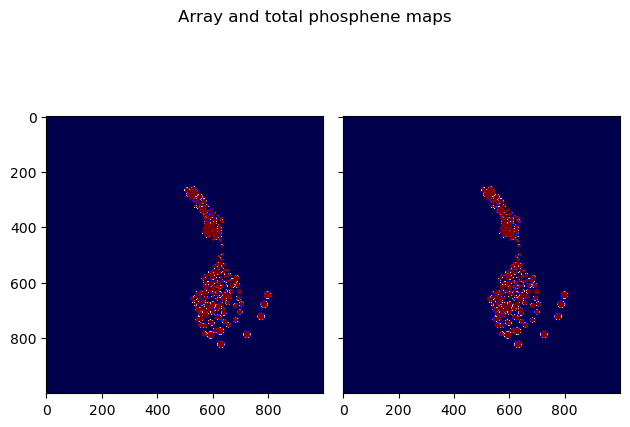

TOTAL VALID GRIDS: 130
TOTAL OVERLAP VALID GRIDS: 150
***********************************
FINISHED ARRAY 1
***********************************
NOW WORKING ON ARRAY 2 OUT OF 5 AND VALID ONES SO FAR ARE 1
Starting iteration: 1
overlap valid: True / convex hull valid: True / cost: 2.9235071246500586 / total cost: 2.6553908819303653
dice: 0.01818 / total dice: 0.19639 / yield: 0.34 / total yield: 0.336 / HD: 0.95868 / total HD: 0.86879
overlap valid: False / convex hull valid: True / cost: 3.649388321964044 / total cost: 3.3987005691337506
dice: 0.03418 / total dice: 0.19992 / yield: 0.201 / total yield: 0.2665 / HD: 0.94362 / total HD: 0.85868
overlap valid: True / convex hull valid: True / cost: 2.924527625608011 / total cost: 2.653373323728492
dice: 0.02205 / total dice: 0.19914 / yield: 0.186 / total yield: 0.259 / HD: 0.95588 / total HD: 0.86181
overlap valid: False / convex hull valid: True / cost: 3.7006549692358517 / total cost: 3.414309414726158
dice: 0.00821 / total dice: 0.18643

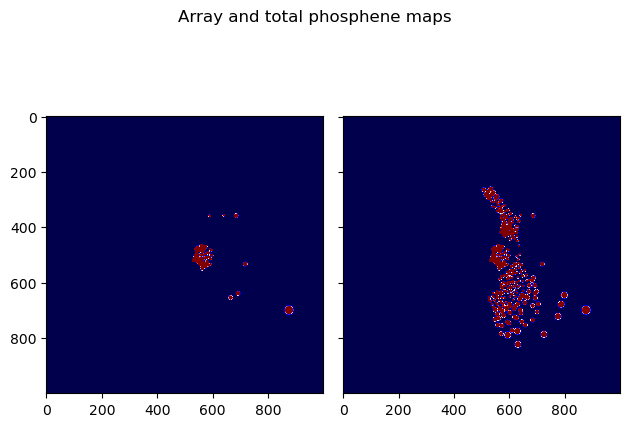

TOTAL VALID GRIDS: 127
TOTAL OVERLAP VALID GRIDS: 137
***********************************
FINISHED ARRAY 2
***********************************
NOW WORKING ON ARRAY 3 OUT OF 5 AND VALID ONES SO FAR ARE 2
Starting iteration: 1
overlap valid: False / convex hull valid: True / cost: 3.673507124650059 / total cost: 3.38083020391653
dice: 0.01818 / total dice: 0.21536 / yield: 0.34 / total yield: 0.29933 / HD: 0.95868 / total HD: 0.86319
overlap valid: True / convex hull valid: False / cost: 3.70738908909804 / total cost: 3.3795563718526545
dice: 0.00969 / total dice: 0.21968 / yield: 0.04 / total yield: 0.19933 / HD: 0.96908 / total HD: 0.85124
overlap valid: False / convex hull valid: True / cost: 3.6097587803383 / total cost: 3.3391795408279736
dice: 0.05234 / total dice: 0.23619 / yield: 0.391 / total yield: 0.31633 / HD: 0.93165 / total HD: 0.84492
overlap valid: False / convex hull valid: True / cost: 3.6610439005158995 / total cost: 3.372581924662434
dice: 0.0262 / total dice: 0.22087

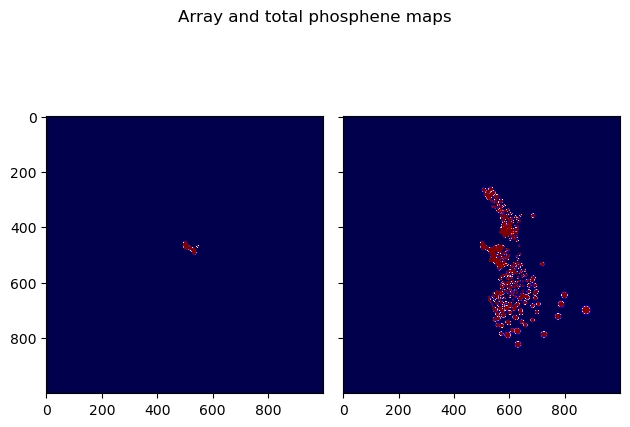

TOTAL VALID GRIDS: 131
TOTAL OVERLAP VALID GRIDS: 136
***********************************
FINISHED ARRAY 3
***********************************
NOW WORKING ON ARRAY 4 OUT OF 5 AND VALID ONES SO FAR ARE 3
Starting iteration: 1
overlap valid: False / convex hull valid: True / cost: 3.673507124650059 / total cost: 3.377754038308292
dice: 0.01818 / total dice: 0.21863 / yield: 0.34 / total yield: 0.308 / HD: 0.95868 / total HD: 0.86339
overlap valid: True / convex hull valid: False / cost: 3.75 / total cost: 3.6067667886772163
dice: 0.0 / total dice: 0.21568 / yield: 0 / total yield: 0.3055 / HD: 1 / total HD: 0.85677
overlap valid: True / convex hull valid: False / cost: 3.709503558940832 / total cost: 3.3787231976281467
dice: 0.00852 / total dice: 0.22243 / yield: 0.036 / total yield: 0.232 / HD: 0.96982 / total HD: 0.85296
overlap valid: False / convex hull valid: True / cost: 3.727372935772719 / total cost: 3.3867651365918072
dice: 0.00237 / total dice: 0.21593 / yield: 0.109 / total yi

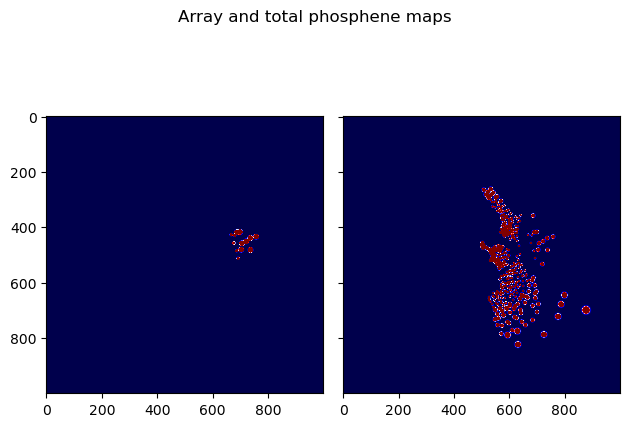

TOTAL VALID GRIDS: 128
TOTAL OVERLAP VALID GRIDS: 132
***********************************
FINISHED ARRAY 4
***********************************
NOW WORKING ON ARRAY 5 OUT OF 5 AND VALID ONES SO FAR ARE 4
Starting iteration: 1
overlap valid: False / convex hull valid: True / cost: 3.673507124650059 / total cost: 3.3592998687164726
dice: 0.01818 / total dice: 0.23223 / yield: 0.34 / total yield: 0.249 / HD: 0.95868 / total HD: 0.85853
overlap valid: True / convex hull valid: False / cost: 3.659308100418963 / total cost: 3.3317786280526596
dice: 0.02918 / total dice: 0.25129 / yield: 0.142 / total yield: 0.2094 / HD: 0.94559 / total HD: 0.84017
overlap valid: True / convex hull valid: False / cost: 3.75 / total cost: 3.6016351302973924
dice: 0.0 / total dice: 0.22931 / yield: 0 / total yield: 0.181 / HD: 1 / total HD: 0.85164
overlap valid: False / convex hull valid: True / cost: 3.678403991725541 / total cost: 3.3614727487112135
dice: 0.01665 / total dice: 0.2318 / yield: 0.317 / total yi

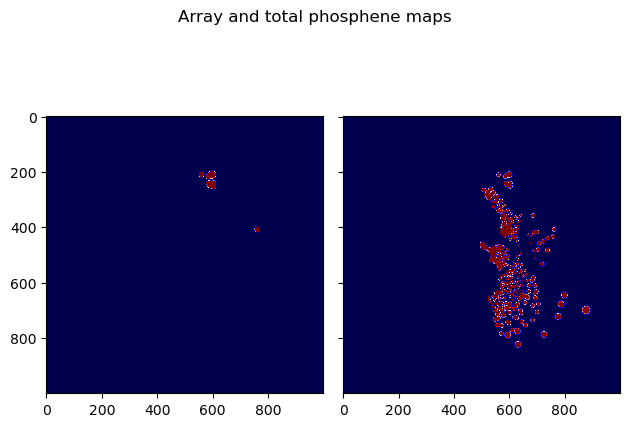

TOTAL VALID GRIDS: 94
TOTAL OVERLAP VALID GRIDS: 104
***********************************
FINISHED ARRAY 5
***********************************
SUBJECT fsaverage, HEMISPHERE RH
NOW WORKING ON ARRAY 1 OUT OF 5 AND VALID ONES SO FAR ARE 0
Starting iteration: 1
overlap valid: True / convex hull valid: True / cost: 2.8969044200005265 / total cost: 2.8969044200005265
dice: 0.03309 / total dice: 0.03309 / yield: 0.332 / total yield: 0.332 / HD: 0.9466 / total HD: 0.9466
overlap valid: True / convex hull valid: True / cost: 2.827196637871525 / total cost: 2.827196637871525
dice: 0.07322 / total dice: 0.07322 / yield: 0.322 / total yield: 0.322 / HD: 0.91651 / total HD: 0.91651
overlap valid: True / convex hull valid: True / cost: 2.896480651906349 / total cost: 2.896480651906349
dice: 0.04195 / total dice: 0.04195 / yield: 0.075 / total yield: 0.075 / HD: 0.94218 / total HD: 0.94218
overlap valid: True / convex hull valid: True / cost: 3.0 / total cost: 3.0
dice: 0.0 / total dice: 0.0 / yield: 

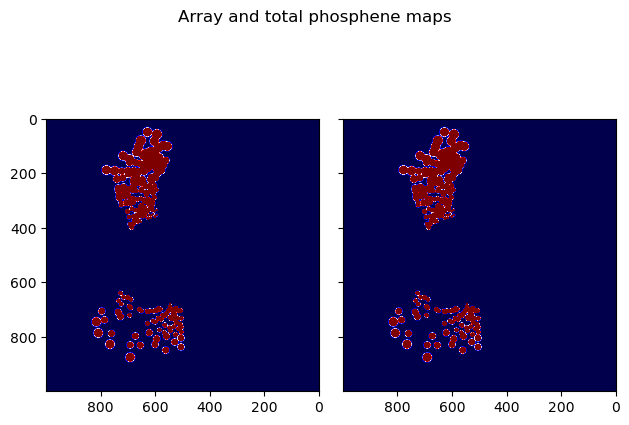

TOTAL VALID GRIDS: 133
TOTAL OVERLAP VALID GRIDS: 150
***********************************
FINISHED ARRAY 1
***********************************
NOW WORKING ON ARRAY 2 OUT OF 5 AND VALID ONES SO FAR ARE 1
Starting iteration: 1
overlap valid: True / convex hull valid: True / cost: 2.8969044200005265 / total cost: 2.403776922248963
dice: 0.03309 / total dice: 0.37338 / yield: 0.332 / total yield: 0.3025 / HD: 0.9466 / total HD: 0.79376
overlap valid: True / convex hull valid: True / cost: 2.825817685657409 / total cost: 2.363195979624115
dice: 0.07541 / total dice: 0.40121 / yield: 0.283 / total yield: 0.278 / HD: 0.91537 / total HD: 0.77856
overlap valid: True / convex hull valid: False / cost: 3.66193104198394 / total cost: 3.162050503671074
dice: 0.02484 / total dice: 0.36757 / yield: 0.261 / total yield: 0.267 / HD: 0.94982 / total HD: 0.79267
overlap valid: True / convex hull valid: True / cost: 3.0 / total cost: 2.800219813392294
dice: 0.0 / total dice: 0.35087 / yield: 0 / total yie

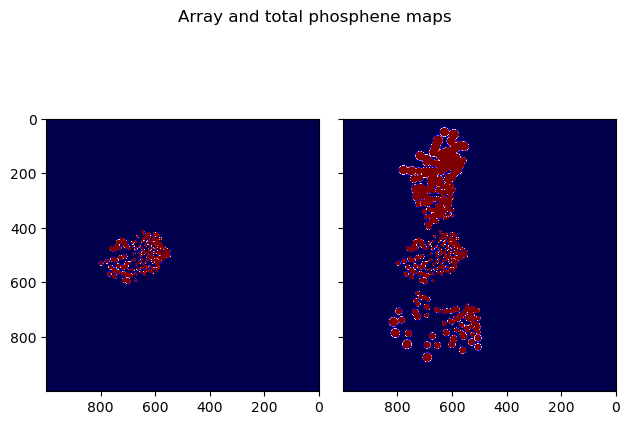

TOTAL VALID GRIDS: 134
TOTAL OVERLAP VALID GRIDS: 144
***********************************
FINISHED ARRAY 2
***********************************
NOW WORKING ON ARRAY 3 OUT OF 5 AND VALID ONES SO FAR ARE 2
Starting iteration: 1
overlap valid: False / convex hull valid: True / cost: 3.6469044200005265 / total cost: 3.0770199645122776
dice: 0.03309 / total dice: 0.42876 / yield: 0.332 / total yield: 0.27833 / HD: 0.9466 / total HD: 0.77238
overlap valid: True / convex hull valid: False / cost: 3.75 / total cost: 3.5227356485118673
dice: 0.0 / total dice: 0.41963 / yield: 0 / total yield: 0.185 / HD: 1 / total HD: 0.77274
overlap valid: False / convex hull valid: True / cost: 3.607993891044464 / total cost: 3.065715583657188
dice: 0.05799 / total dice: 0.43754 / yield: 0.215 / total yield: 0.23933 / HD: 0.92673 / total HD: 0.764
overlap valid: False / convex hull valid: False / cost: 3.6183536086499615 / total cost: 3.054397012032716
dice: 0.04588 / total dice: 0.4419 / yield: 0.296 / total 

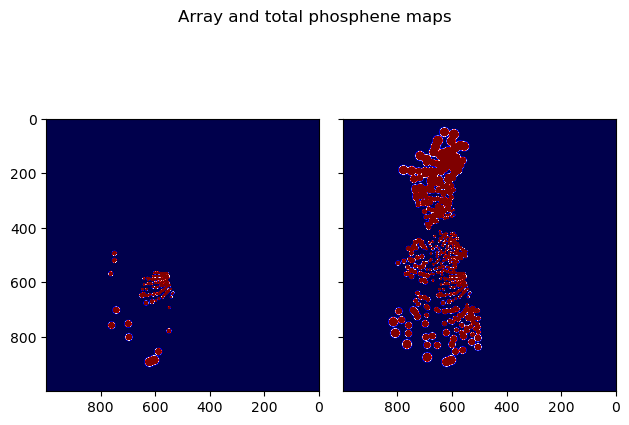

TOTAL VALID GRIDS: 107
TOTAL OVERLAP VALID GRIDS: 119
***********************************
FINISHED ARRAY 3
***********************************
NOW WORKING ON ARRAY 4 OUT OF 5 AND VALID ONES SO FAR ARE 3
Starting iteration: 1
overlap valid: False / convex hull valid: True / cost: 3.6469044200005265 / total cost: 3.020656102054053
dice: 0.03309 / total dice: 0.46959 / yield: 0.332 / total yield: 0.273 / HD: 0.9466 / total HD: 0.75684
overlap valid: False / convex hull valid: True / cost: 3.6351309008133494 / total cost: 3.0201336243379577
dice: 0.04196 / total dice: 0.47119 / yield: 0.227 / total yield: 0.24675 / HD: 0.93844 / total HD: 0.75267
overlap valid: False / convex hull valid: True / cost: 3.4660330786674125 / total cost: 2.9841175862372156
dice: 0.14446 / total dice: 0.49116 / yield: 0.38 / total yield: 0.285 / HD: 0.87949 / total HD: 0.74428
overlap valid: False / convex hull valid: True / cost: 3.386673915617241 / total cost: 2.9727383157529577
dice: 0.21024 / total dice: 0.5

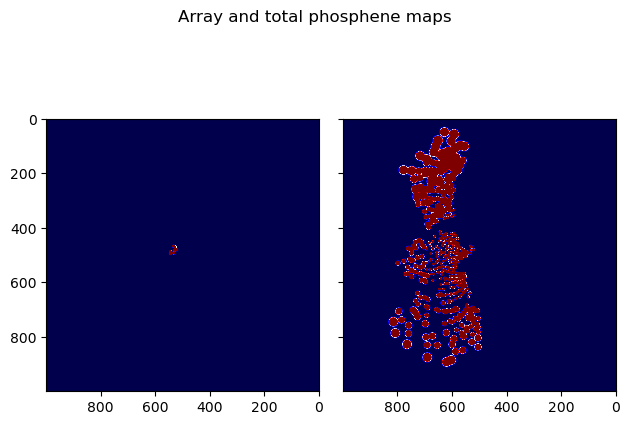

TOTAL VALID GRIDS: 133
TOTAL OVERLAP VALID GRIDS: 136
***********************************
FINISHED ARRAY 4
***********************************
NOW WORKING ON ARRAY 5 OUT OF 5 AND VALID ONES SO FAR ARE 4
Starting iteration: 1
overlap valid: False / convex hull valid: True / cost: 3.6469044200005265 / total cost: 3.0188553434147214
dice: 0.03309 / total dice: 0.47086 / yield: 0.332 / total yield: 0.2846 / HD: 0.9466 / total HD: 0.75631
overlap valid: True / convex hull valid: True / cost: 3.0 / total cost: 2.755823424908833
dice: 0.0 / total dice: 0.46368 / yield: 0 / total yield: 0.2314 / HD: 1 / total HD: 0.75582
overlap valid: False / convex hull valid: True / cost: 3.5825412862138086 / total cost: 2.999101868774864
dice: 0.07022 / total dice: 0.48265 / yield: 0.288 / total yield: 0.2758 / HD: 0.91716 / total HD: 0.74616
overlap valid: False / convex hull valid: True / cost: 3.6500720360950187 / total cost: 3.025921678893928
dice: 0.03596 / total dice: 0.46831 / yield: 0.19 / total yi

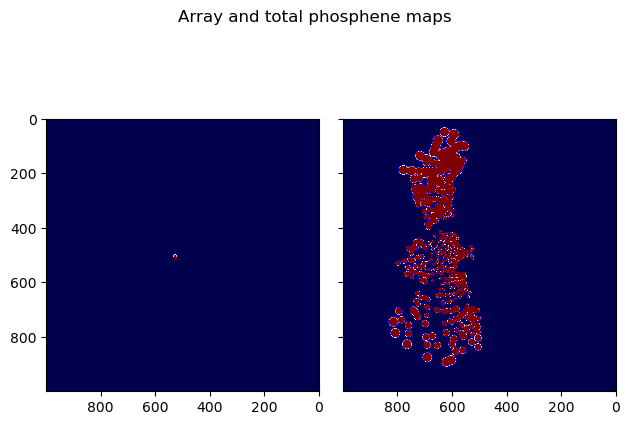

TOTAL VALID GRIDS: 131
TOTAL OVERLAP VALID GRIDS: 136
***********************************
FINISHED ARRAY 5
***********************************


In [5]:
subj_list = ["fsaverage"]
for sub in subj_list:
    run(sub)